## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"/Users/brtelfer/Documents/Personal Stuff/Python_Data_Projects/School Project/{f}")
    data[key_name] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("/Users/brtelfer/Documents/Personal Stuff/Python_Data_Projects/School Project/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("/Users/brtelfer/Documents/Personal Stuff/Python_Data_Projects/School Project/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined = combined.copy()
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
sat_cor = combined.corr(numeric_only=True)['sat_score'].loc[survey_fields]
sat_cor

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

## Creating a data dictionary the dataframe

In [119]:
key = ['dbn',
'sch_type',
'location',
'enrollment',
'borough',
'principal',
'studentsurvey',
'rr_s',
'rr_t',
'rr_p',
'N_s',
'N_t',
'N_p',
'nr_s',
'nr_t',
'nr_p',
'saf_p_11',
'com_p_11',
'eng_p_11',
'aca_p_11',
'saf_t_11',
'com_t_11',
'eng_t_11',
'aca_t_11',
'saf_s_11',
'com_s_11',
'eng_s_11',
'aca_s_11',
'saf_tot_11',
'com_tot_11',
'eng_tot_11',
'aca_tot_11']


value = ['School identification code (district borough number)',
'School type (Elementary, Middle, High, etc)',
'School name',
'Enrollment size',
'Borough',
'Principal name',
'Only students in grades 6-12 partipate in the student survey. This field indicates whether or not this school serves any students in grades 6-12.',
'Student Response Rate',
'Teacher Response Rate',
'Parent Response Rate',
'Number of student respondents',
'Number of teacher respondents',
'Number of parent respondents',
'Number of eligible students',
'Number of eligible teachers',
'Number of eligible parents',
'Safety and Respect score based on parent responses',
'Communication score based on parent responses',
'Engagement score based on parent responses',
'Academic expectations score based on parent responses',
'Safety and Respect score based on teacher responses',
'Communication score based on teacher responses',
'Engagement score based on teacher responses',
'Academic expectations score based on teacher responses',
'Safety and Respect score based on student responses',
'Communication score based on student responses',
'Engagement score based on student responses',
'Academic expectations score based on student responses',
'Safety and Respect total score',
'Communication total score',
'Engagement total score',
'Academic Expectations total score']

data_dict = {}
for a, b in zip(key, value):
    data_dict[a] = b
    
print(data_dict)

{'dbn': 'School identification code (district borough number)', 'sch_type': 'School type (Elementary, Middle, High, etc)', 'location': 'School name', 'enrollment': 'Enrollment size', 'borough': 'Borough', 'principal': 'Principal name', 'studentsurvey': 'Only students in grades 6-12 partipate in the student survey. This field indicates whether or not this school serves any students in grades 6-12.', 'rr_s': 'Student Response Rate', 'rr_t': 'Teacher Response Rate', 'rr_p': 'Parent Response Rate', 'N_s': 'Number of student respondents', 'N_t': 'Number of teacher respondents', 'N_p': 'Number of parent respondents', 'nr_s': 'Number of eligible students', 'nr_t': 'Number of eligible teachers', 'nr_p': 'Number of eligible parents', 'saf_p_11': 'Safety and Respect score based on parent responses', 'com_p_11': 'Communication score based on parent responses', 'eng_p_11': 'Engagement score based on parent responses', 'aca_p_11': 'Academic expectations score based on parent responses', 'saf_t_11':

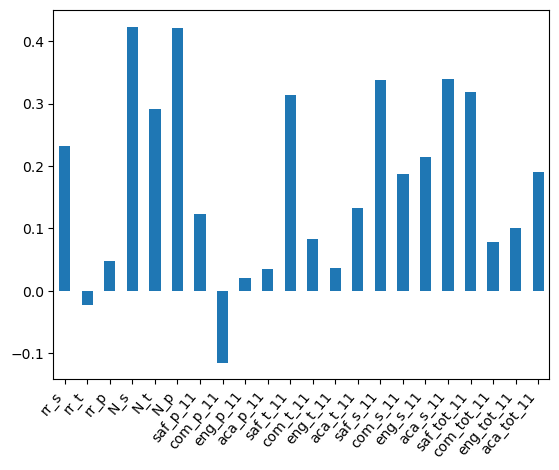

In [13]:
sat_cor.plot.bar()
plt.xticks(rotation=50, ha='right')
plt.show()

In [14]:
print(f"The {data_dict['N_s']}, and {data_dict['N_p']} are the most highly correlated with the SAT score")

The Number of student respondents, and Number of parent respondents are the most highly correlated with the SAT score


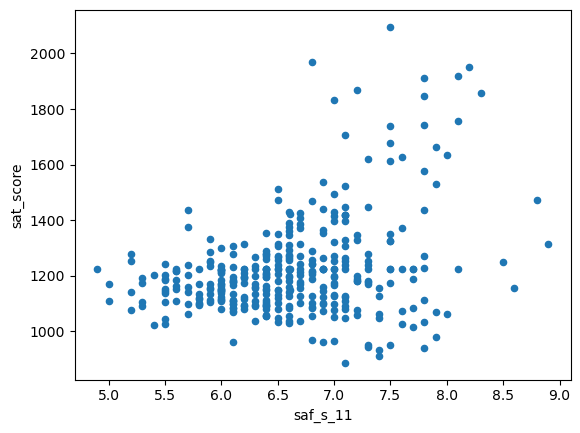

In [15]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

In [16]:
# There appears to be a largely positive, exponential relation between the
# sat_score and the saf_s_11, which largely takes off at around saf 7.0
# This suggests that when the safety meets a certain threshold, it might be impacting
# Scores by a lot

In [17]:
combined.columns[combined.columns.str.startswith(r'b')]

Index(['black_num', 'black_per', 'boro', 'building_code', 'bus'], dtype='object')

In [18]:
combined.groupby('boro').mean(numeric_only=True)['saf_s_11'].sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

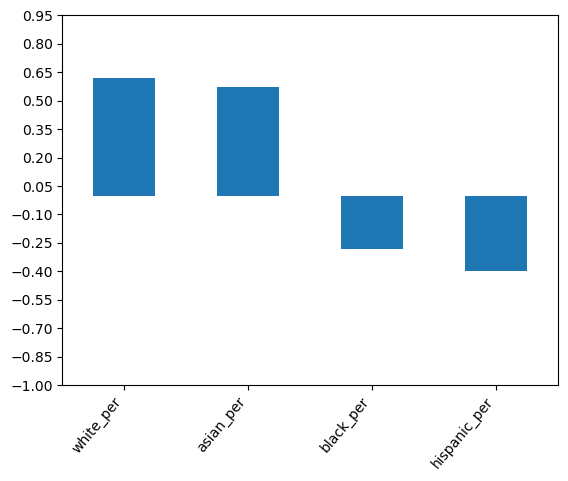

In [19]:
import numpy as np

race_lst = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

sat_cor = combined.corr(numeric_only=True)['sat_score'].loc[race_lst]

sat_cor.plot.bar()
plt.xticks(rotation=50, ha='right')
plt.yticks(np.arange(-1, 1, step=0.15))
plt.show()

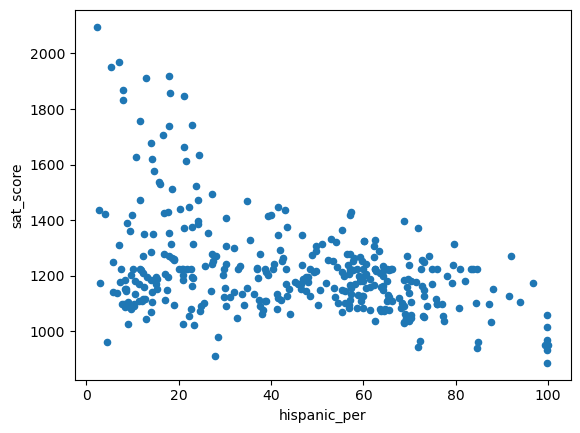

In [20]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.show()

In [21]:
# There appears to be a negative linear relationship between the sat_scores and 
# the hispanic percentage. We should investigate schools that have a percentage
# greater than or equal to 95%

In [22]:
hispanic_bool = combined['hispanic_per'] >= 95.0
combined['SCHOOL NAME'][hispanic_bool]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [23]:
combined.columns[combined.columns.str.startswith(r'S')]

Index(['SCHOOL NAME', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'SchoolName', 'School Name',
       'Still Enrolled - n', 'Still Enrolled - % of cohort',
       'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'SCHOOLWIDE PUPIL-TEACHER RATIO'],
      dtype='object')

In [24]:
combined['SCHOOL NAME'].unique()[0:5]

array(['HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES',
       'UNIVERSITY NEIGHBORHOOD HIGH SCHOOL',
       'EAST SIDE COMMUNITY SCHOOL', 'MARTA VALLE HIGH SCHOOL',
       'NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL'],
      dtype=object)

In [25]:
combined[['SCHOOL NAME']][hispanic_bool]

,SCHOOL NAME
44,MANHATTAN BRIDGES HIGH SCHOOL
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253,MULTICULTURAL HIGH SCHOOL
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL


In [26]:
# It appears that these schools are largely for immigrants who may not have grown
# Up speaking English as a native language

In [27]:
hispanic_bool = (combined['hispanic_per'] < 10.0) & (combined['sat_score'] < 1800)
combined['SCHOOL NAME'][hispanic_bool]

46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           BROOKLYN GENERATION SCHOOL
240              KURT HAHN EXPEDITIONARY LEARNING SCHOOL
241                       VICTORY COLLEGIATE HIGH SCHOOL
242                     ARTS & 

In [28]:
# A lot of these schools appear to be college prepatory which may explain the
# Higer SAT scores

<Axes: >

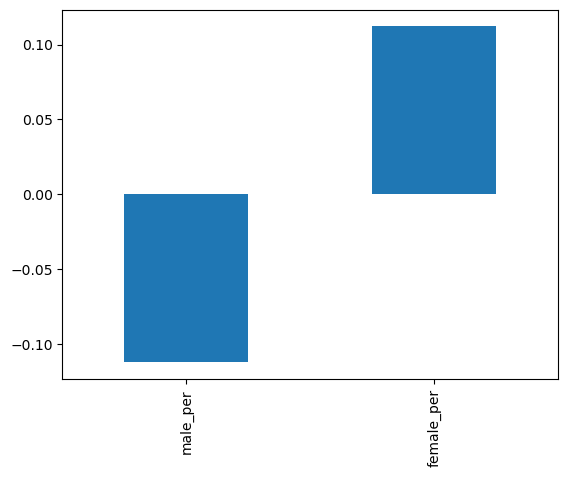

In [29]:
gender_fields = ["male_per", "female_per"]
combined.corr(numeric_only=True)["sat_score"][gender_fields].plot.bar()

In [30]:
# It appears like there is a small negative correlation between being male and doing
# Well on the SAT vs being female

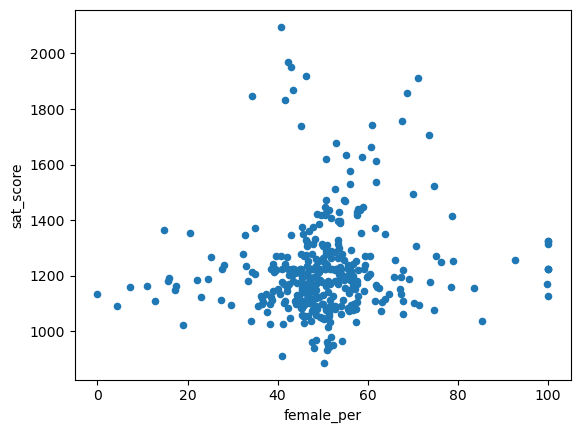

In [31]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

In [32]:
# There is a lot of distribution of scores with clustering at aronud 50% female and
# 1000 to 1400 SAT scores

In [33]:
combined['SCHOOL NAME'][(combined['female_per'] > 60.0) & (combined['sat_score'] >= 1700)]


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [34]:
# These are all specialized, academically rigorous public high schools in New York City

In [35]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

In [36]:
combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

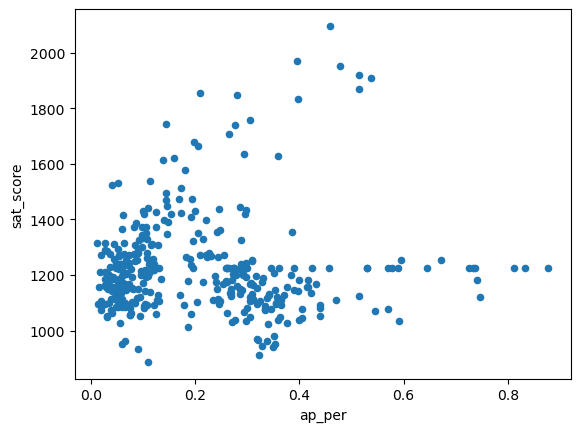

In [37]:
combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()

In [38]:
# It appears that there is quite a lot of clustering of where both scores and the
# Percentage of AP Test Takers is low

In [39]:
test_dict = {}
for key, value in zip(data_dict.keys(),data_dict.values()):
    if 'SIZE' in value:
        test_dict[key] = value

In [40]:
test_dict

{}

In [41]:
combined.columns[combined.columns.str.contains(r'SIZE')]

Index(['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
       'SIZE OF LARGEST CLASS'],
      dtype='object')

In [42]:
combined['AVERAGE CLASS SIZE']

0      22.564286
1      22.231250
2      21.200000
3      23.571429
4      25.510526
         ...    
358    22.958824
359    22.760000
360    23.900000
361    17.793750
362    25.060000
Name: AVERAGE CLASS SIZE, Length: 363, dtype: float64

In [43]:
combined.corr(numeric_only=True)['sat_score']['AVERAGE CLASS SIZE']

0.3810143308095529

In [44]:
# There is a moderate positive correlation between sat and the average class size

In [45]:
# Now, we should identify which schools are actually the best
# By considering multiple things

In [ ]:
# We will use the following things: 
# least expensive neighborhoods
# Good sat scores
# Small average class sizes
# With a balanced distribution of races
# And very high:
# saf_p_11
# com_p_11
# eng_p_11
# aca_p_11
# saf_t_11
# com_t_11
# eng_t_11
# aca_t_11
# saf_s_11
# com_s_11
# eng_s_11
# aca_s_11
# saf_tot_11
# com_tot_11
# eng_tot_11
# aca_tot_11
# But I will rank the weight of each based on correlation to sat_scores

In [47]:
# The first step is to get a list of everything we need

In [51]:
# Sadly, it does not appear that we have any data that directly tells us what the
# Least expensive neighborhoods are. Yet, there are a few data we could use:
# frl_percent probably stands for free lunch percent, which can indicate
# the socioeconomic status of schools. To assess this casually, one can
# Investigate a few schools with high vs low percents

In [53]:
combined.corr(numeric_only=True)['frl_percent']['sat_score']
# We can see that there is a very negative correlation between the different scores

-0.7222246349966361

In [55]:
combined.corr(numeric_only=True)['frl_percent']['AVERAGE CLASS SIZE']
# We can see that there is a very negative correlation between the different scores

-0.40065061672411584

In [61]:
combined['saf_p_11']

0      7.8
1      7.9
2      8.7
3      7.7
4      8.5
      ... 
358    8.0
359    8.2
360    7.9
361    9.4
362    8.5
Name: saf_p_11, Length: 363, dtype: float64

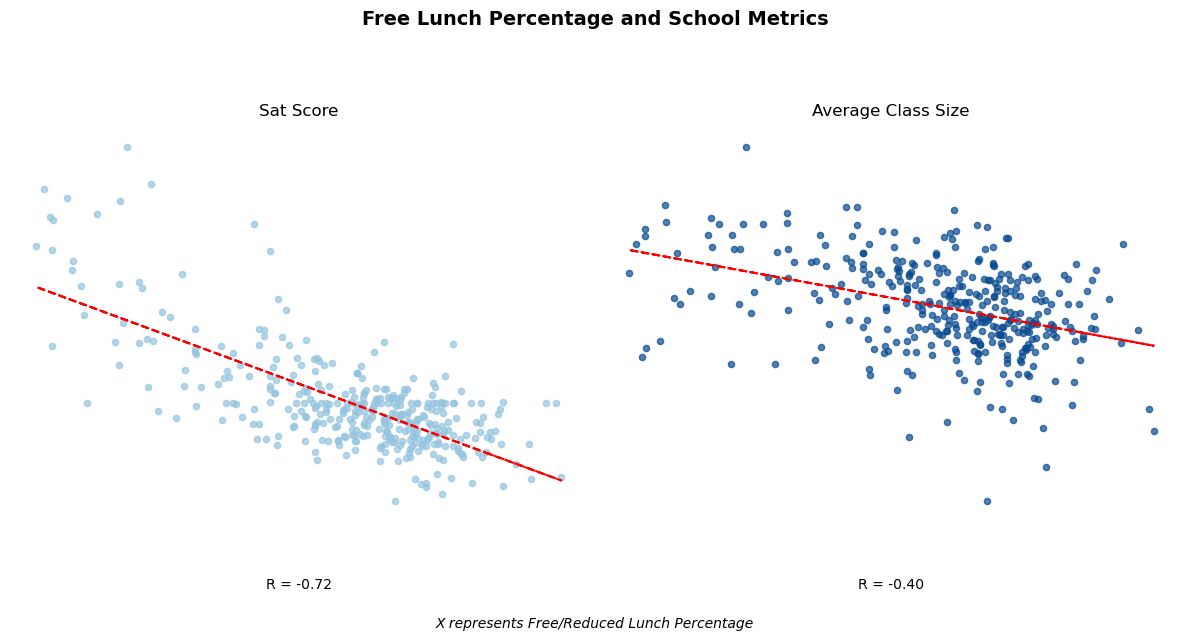

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

a_lst = ['sat_score', 'AVERAGE CLASS SIZE']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes = axes.flatten()

# Monochrome color palette (blue gradient)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(a_lst)))

for value, ax, color in zip(a_lst, axes, colors):
    # Scatter plot
    combined.plot.scatter(x='frl_percent', y=value, ax=ax, color=color, alpha=0.7)
    
    # Calculate correlation and trendline
    x = combined['frl_percent']
    y = combined[value]
    mask = ~np.isnan(x) & ~np.isnan(y)
    r_value = x[mask].corr(y[mask])
    slope, intercept, _, _, _ = stats.linregress(x[mask], y[mask])
    
    # Plot red trendline
    ax.plot(x, intercept + slope * x, color='red', linewidth=1.5, linestyle='--')
    
    # Add title and R value
    ax.set_title(value.replace('_', ' ').title(), fontsize=12, pad=10)
    ax.text(0.5, -0.15, f'R = {r_value:.2f}', transform=ax.transAxes,
            ha='center', va='top', fontsize=10)
    
    # Remove all axis labels and ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Main title at top
fig.suptitle('Free Lunch Percentage and School Metrics', 
             y=1.05, x=0.5, fontsize=14, fontweight='bold')

# Footer explaining x-axis
fig.text(0.5, 0.02, 'X represents Free/Reduced Lunch Percentage', 
         ha='center', fontsize=10, style='italic')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.2)
plt.show()

In [135]:
survey_lst = []
for value in data_dict:
    if '_11' in value:
        survey_lst.append(data_dict[value])

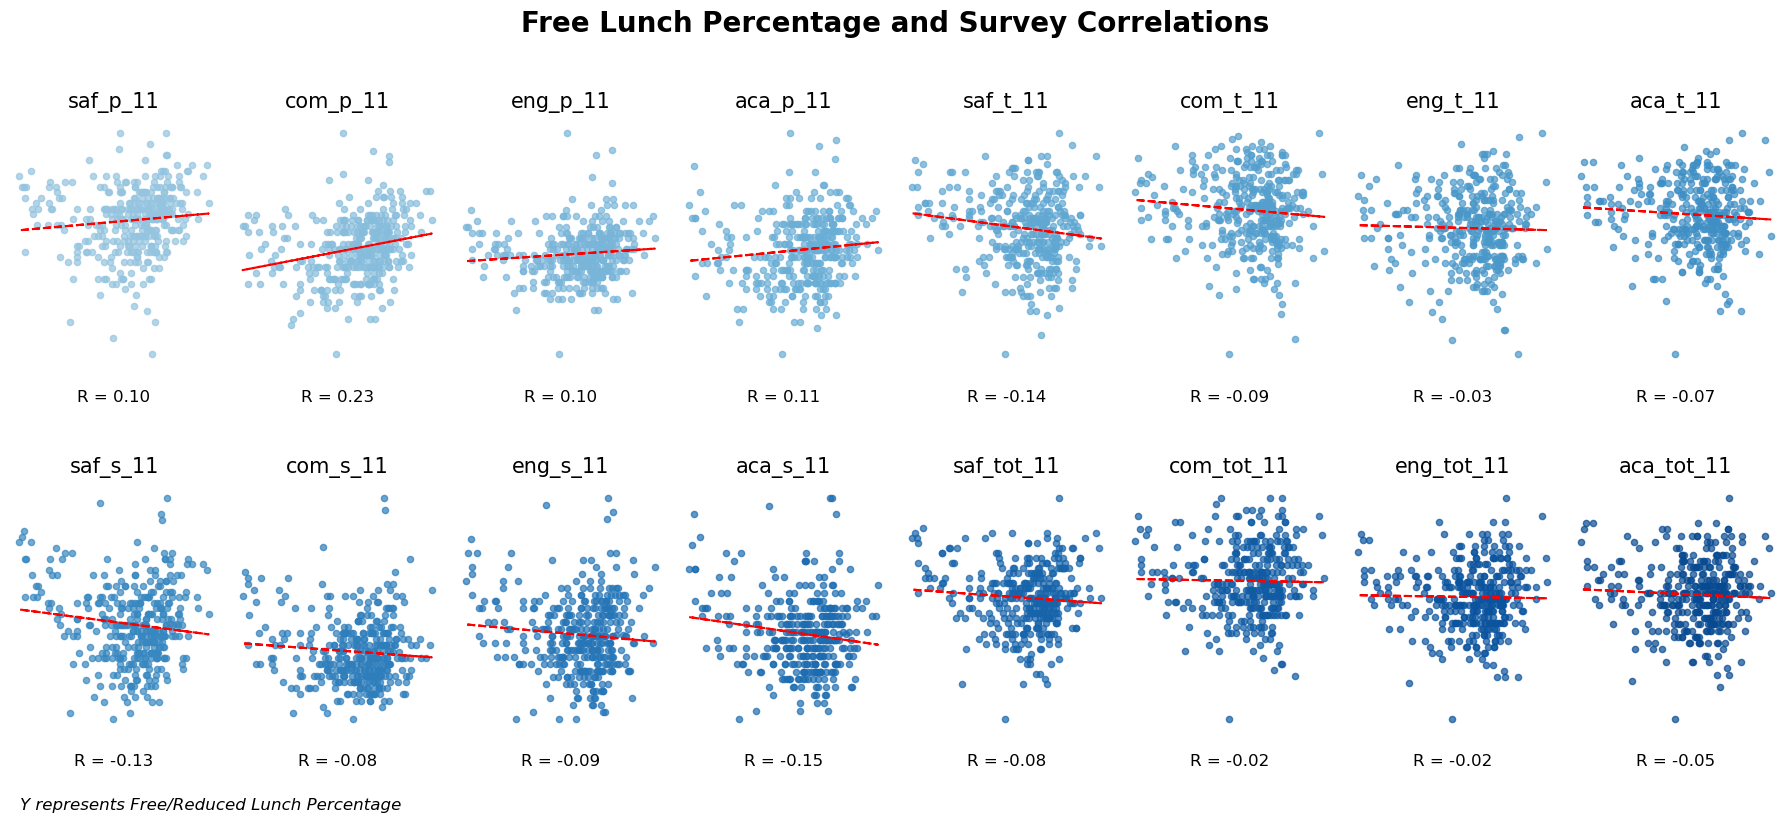

In [ ]:
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

survey_lst = ['saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11',
              'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11',
              'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
              'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(18, 8))
axes = axes.flatten()

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(survey_lst)))

for value, ax, color in zip(survey_lst, axes, colors):
    combined.plot.scatter(x='frl_percent', y=value, ax=ax, color=color, alpha=0.7)
    
    x = combined['frl_percent']
    y = combined[value]
    mask = ~np.isnan(x) & ~np.isnan(y)
    r_value = x[mask].corr(y[mask])
    slope, intercept, _, _, _ = stats.linregress(x[mask], y[mask])
    
    ax.plot(x, intercept + slope * x, color='red', linewidth=1.5, linestyle='--')
    
    ax.set_title(value, fontsize=15, pad=10)
    
    ax.text(0.5, -0.1, f'R = {r_value:.2f}', transform=ax.transAxes,
            ha='center', va='top', fontsize=12)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.suptitle('Free Lunch Percentage and Survey Correlations', 
             y=1.02, x=0.5, fontsize=20, fontweight='bold')

fig.text(0.12, 0.02, 'Y represents Free/Reduced Lunch Percentage', 
         ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.12, hspace=0.5)
plt.show();

In [143]:
survey_lst

['Safety and Respect score based on parent responses',
 'Communication score based on parent responses',
 'Engagement score based on parent responses',
 'Academic expectations score based on parent responses',
 'Safety and Respect score based on teacher responses',
 'Communication score based on teacher responses',
 'Engagement score based on teacher responses',
 'Academic expectations score based on teacher responses',
 'Safety and Respect score based on student responses',
 'Communication score based on student responses',
 'Engagement score based on student responses',
 'Academic expectations score based on student responses',
 'Safety and Respect total score',
 'Communication total score',
 'Engagement total score',
 'Academic Expectations total score']

In [151]:
cor_lst = []

for value in survey_lst:
    x = combined['frl_percent']
    y = combined[value]
    mask = ~np.isnan(x) & ~np.isnan(y)
    r_value = x[mask].corr(y[mask])
    cor_lst.append(r_value)

sum(cor_lst)/len(cor_lst)

-0.025457501232716645

In [ ]:
# There is only a slight negative correlation between all of these positive survey scores and frl_percent and it is pretty trivial even if significant
# Now, onto a balanced a balanced distribution of races. In the US, the average distributions of race are roughly:

# White: 60%
# Black: 12.5%
# Asian alone: 6%
# Hispanic or Latino: 20%

# According to the https://www.equityinhighered.org/indicators/u-s-population-trends-and-educational-attainment/race-and-ethnicity-of-the-u-s-population/

In [185]:
race_cols = combined.columns[combined.columns.str.contains(r'(black|hispanic|white|asian)_per')].to_list()
expected_per = {'black': 12.5, 'hispanic': 20, 'white': 60, 'asian': 6}

for col, value in zip(race_cols, expected_per.values()):
    combined[f'{col}_dif'] = combined[col] - value

In [186]:
# This is very crude, but for the scope of this project, it will suffice
combined['black_per_dif'].mean()

16.575206611570245

In [ ]:
combined[['black_per','hispanic_per','white_per','asian_per']].mean()
# This suggests that this particular dataframe is very different than normal, we would expect the means of these percentages to be similar to the expected per, however they
# Are very different. Therefore, it might not be appropriate to treat this dataframe normally.

black_per       36.575207
hispanic_per    44.068320
white_per        8.430028
asian_per       10.149587
dtype: float64

In [199]:
# We should instead look to find schools with very high survey_lst values
survey_lst = []
for value in data_dict:
    if 'tot' in value:
        survey_lst.append(data_dict[value])

In [200]:
survey_lst

['Safety and Respect total score',
 'Communication total score',
 'Engagement total score',
 'Academic Expectations total score']

In [211]:
# We will use:
survey_scores = ['saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']
min_max_sur = {}
for survey in survey_scores:
    min_max_sur[survey] = f'Min: {combined[survey].min()}, Max: {combined[survey].max()}'

In [212]:
min_max_sur

{'saf_tot_11': 'Min: 4.9, Max: 9.3',
 'com_tot_11': 'Min: 4.5, Max: 8.1',
 'eng_tot_11': 'Min: 5.0, Max: 8.7',
 'aca_tot_11': 'Min: 5.6, Max: 9.1'}

In [ ]:
# This gives us an idea about what the min and max thresholds are for each survey and whether they are on the same scale or different scales
# However, we really want to make sure we have this right, so we ought to go about it very differently
# I will start by getting the survey values, then stacking them onto eachother with stack and then getting the min and max of ALL rather than EACH

In [218]:
survey_lst = ['saf_p_11',
'com_p_11',
'eng_p_11',
'aca_p_11',
'saf_t_11',
'com_t_11',
'eng_t_11',
'aca_t_11',
'saf_s_11',
'com_s_11',
'eng_s_11',
'aca_s_11',
'saf_tot_11',
'com_tot_11',
'eng_tot_11',
'aca_tot_11']

combined[survey_lst].stack().nlargest(1)

111  aca_t_11    9.8
dtype: float64

In [219]:
combined[survey_lst].stack().nsmallest(1)

222  com_t_11    1.9
dtype: float64

In [ ]:
# So, I can reasonably assume the largest possible is 10 and the smallest possible is 0